In [1]:
from edc import check_compatibility
check_compatibility("user-2022.10-14", dependencies=["xcube"])



---------

The following environment variables are available:


-------------
No environment variables for **xcube** found.


# Exploring the CLMS HR-S&I dataset using Datacubes
---

In this demonstration Jupyter Notebook, we will be requesting and visualising CLMS HR-S&I data with xcube in the EDC EOxHub Workplace. In this notebook we will:

- Generate an AOI over Sölden, Austria.
- Visualise the Wet Snow Map for a single date.
- Visualise the Snow State Classification over several dates.
- Compare Persistent Snow Area between different years.
- Plot a time series of Gap-filled Fractional Snow Cover for a smaller area over a season.


## A quick guide to xcube

- xcube is an open-source Python package and toolkit that has been developed to provide Earth observation (EO) data in an analysis-ready form to users. xcube achieves this by carefully converting EO data sources into self-contained data cubes that can be published in the cloud.
- An xcube dataset contains one or more (geo-physical) data variables whose values are stored in cells of a common multi-dimensional, spatio-temporal grid. The dimensions are usually time, latitude, and longitude, however other dimensions may be present.

[xcube documentation](https://xcube.readthedocs.io/en/latest/)

## Copernicus land monitoring service - High resolution snow & ice monitoring

The High-Resolution Snow & Ice Monitoring service (HR-S&I) is part of the Copernicus Land Monitoring Service (CLMS). The snow aspect of the service provides products measuring Snow cover (FSC, FSTOC, FSCOG, GFSC), Snow state conditions (WDS, SWS) and persistent snow area (PSA).

[Source](https://land.copernicus.eu/pan-european/biophysical-parameters/high-resolution-snow-and-ice-monitoring/snow-products)


### Accessing the data via the cloud

- The dataset is provided by WEkEO, meaning it is stored in Creodias S3 object storage.
- Meaning it is stored in Cloud-optimised GeoTIFF format. 
- Easily ingested into Sentinel Hub services via the BYOC API.
- Can then be easily integrated into EDC.


## Prerequisites

Before acccessing the data, we will start by importing the necessary Python libraries (already configured in your EDC workspace) and generate credentials automatically to access the services.

In [2]:
# Utilities
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import IPython.display
from os import environ 
import matplotlib.pyplot as plt

import collection_ids


# EDC Libraries 
from edc import setup_environment_variables
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from xcube.core.geom import mask_dataset_by_geometry

# Sentinel Hub
from sentinelhub import (SHConfig, SentinelHubRequest, DataCollection, MimeType, BBox, bbox_to_dimensions)

# Fetch credentials as environement variables
setup_environment_variables()

# Pass Sentinel Hub credentials to dictionnary
sh_credentials = dict(client_id=environ["SH_CLIENT_ID"],
                      client_secret=environ["SH_CLIENT_SECRET"])

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:
* `GEODB_API_SERVER_PORT`, `GEODB_API_SERVER_URL`, `GEODB_AUTH_AUD`, `GEODB_AUTH_CLIENT_ID`, `GEODB_AUTH_CLIENT_SECRET`, `GEODB_AUTH_DOMAIN`
* `SH_CLIENT_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`, `SH_INSTANCE_ID`



In the below cell, we define a custom function for configuring our datacube:

In [3]:
def create_xcube_data(band_names, aoi_coords, proj_code, collection_id, sh_credentials, time_range, no_data = None, spatial_res = 10, creodias = False, datatype  = 'UINT16'):
    """Create a datacube from a certain collection ID. This datacube will be clipped to a certain bounding box. 
     
    :param band_names: list of bands that need to be requested for the collection #check the documentation to know the available bands. 
    :type band_names: list
    :param aoi_coords: 4 corner coordinates in the projection (see param: 'proj_code') for which the data should be requested 
    :type aoi_coords: tupe with ints or floats
    :param proj_code : url to the projection code in which the datacube should be delivered
    :type proj_code: str
    :param collection_id: the ID of the collection in the EDC to get access to it
    :type collection_id: str
    :param sh_credentials: EDC credentials to access the collection
    :param time_range: the time range for which the data should be requested
    :type time_range: list with str of time range e.g. [2018-01-01,2018-12-31]
    :param no_data: identify the nodata value of the collection
    :type time_range: integer value corresponding to the nodata value
    :param spatial_res (optional): the spatial resolution in which the data should be resampled. 
    :type  spatial_res: int
    :param creodias (optional): define if the requested data originates from creodias (as is the case for HR-VPP data)
    :type creodias: boolean
    :param datatype: specify in which format the output values should be delivered
    :type datatype: str
    
    
    :return: datacube with the loaded collection 
    :rtype: Xarray dataset
    """
    aoi_coords = (aoi_coords[0]-spatial_res, aoi_coords[1]-spatial_res, aoi_coords[2] + spatial_res, aoi_coords[3] + spatial_res)

    cube_config = CubeConfig(dataset_name='CUSTOM',
                         band_names=band_names,
                         bbox=aoi_coords,
                         crs = proj_code,
                         time_range= time_range,
                         time_period=None,
                         spatial_res=spatial_res,
                         band_sample_types=datatype,
                         collection_id=collection_id,
                         band_fill_values = no_data
                         )
    
    if creodias:
        out_cube = open_cube(cube_config, **sh_credentials, api_url="https://creodias.sentinel-hub.com")
    else:
        out_cube = open_cube(cube_config, **sh_credentials)
  
    return out_cube

***Define an AOI***

Next, we will define our area of interest using a bounding box. This must be provided in WGS84 coordinates to build the cube. But later, we will clip this further using a GeoJSON to a far better defined AOI. We have chosen an AOI over Sölden, Austria for this demonstration. 

In [4]:
# Bbox
aoi_coords = [
  10.70251,
  46.74833,
  11.287466,
  47.100045
]

# Bbox EPSG
bbox_epsg = 4326

In [5]:
# Plot the bounding box on a map
IPython.display.GeoJSON(BBox(aoi_coords,crs=bbox_epsg).get_geojson())

<IPython.display.GeoJSON object>

In [6]:
projection_code_LAEA = "http://www.opengis.net/def/crs/EPSG/0/4326" #default used projection
spatial_res_sws = 0.000540  # in degrees

## Visualising the SAR Wet Snow in high mountains dataset for a single date

***Build an xcube***

In the following cell we will specify the input parameters needed to build an xcube array. The following parameters are specified:

- _band_names_: the band names to be used in the xcube array. Here, we will call the WSM, QCWSM and dataMask bands.

- _bbox_: the bounding box that sets the extent of the AOI. 

- _spatial_res_: the spatial resolution of the rasters contained in the xcube array. The spatial resolution is expressed in the units of the coordinate system used. Therefore, in this example, the spatial resolution is set in degrees. For an approximate pixel size of 60 meters, we set the resolution to 0.000540 degrees.

- _time_range_: a list of two dates [start_date, end_date] forming a time period for which all acquisitions will be returned. In this example, we will fetch data for December 2020 - May 2021.

_Note: the `return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)` warning can be safely ignored._

In [7]:
sws_bands = ['WSM', 'QCWSM', 'dataMask']
sws_xcube = create_xcube_data(
    sws_bands, 
    aoi_coords, 
    projection_code_LAEA, 
    collection_ids.wsm_collection, 
    sh_credentials, 
    ['2020-12-01','2021-05-31'], 
    no_data=np.nan,
    spatial_res=spatial_res_sws,
    creodias=True)

/opt/conda/envs/edc-default-2022.10-14/lib/python3.9/site-packages/xcube_sh/config.py:248: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  time_tolerance = pd.to_timedelta(time_tolerance)


***Open the xcube***

In the following cell we open the cube and display its contents. The automatically generated credentials obtained earlier in this Jupyter Notebook are specified as a parameter when opening the cube. It's important to note that at this stage, we're not processing anything, just generating a cube on the fly with data ready to be called when needed for analysis.

Once you open the cube, you can visualise the contents. You can view the number of timestamps and a list of them all too in the Coordinates tab. You can also visualise the seperate variables, with information on the size of the variables and their data type too.  

In [8]:
sws_xcube

<xarray.Dataset>
Dimensions:    (time: 169, lat: 653, lon: 1085, bnds: 2)
Coordinates:
  * lat        (lat) float64 47.1 47.1 47.1 47.1 ... 46.75 46.75 46.75 46.75
  * lon        (lon) float64 10.7 10.7 10.7 10.7 ... 11.29 11.29 11.29 11.29
  * time       (time) datetime64[ns] 2020-12-01T05:35:06 ... 2021-05-30T05:35:06
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(169, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    QCWSM      (time, lat, lon) uint16 dask.array<chunksize=(1, 653, 1085), meta=np.ndarray>
    WSM        (time, lat, lon) uint16 dask.array<chunksize=(1, 653, 1085), meta=np.ndarray>
    dataMask   (time, lat, lon) uint16 dask.array<chunksize=(1, 653, 1085), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   CUSTOM Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2023-01-20T03:51:51.462867
    time_coverage_start:     2020-12-01T05:35:06+00:00
    time_coverage_end:       2021-05-30T05:35:06+00:00
    time_coverage_duration:  P180DT0H0M0S
    geospatial_lon_min:      10.70197
    geospatial_lat_min:      46.74779
    geospatial_lon_max:      11.28787
    geospatial_lat_max:      47.100410000000004

Next, let's visualise one of the timestamps of our area of interest. To do this we can select a time and visualise it with the below cell. We will use Matplotlib to achieve this. 

*Table: Wet Snow Classification classes are split into the following;*

<table>
  <thead>
    <tr>
      <th>Value</th>
      <th>Color</th>
      <th>Label</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td style="background-color: #ff4dff;"></td>
      <td>110 - Wet snow</td>
    </tr>
    <tr>
      <td>2</td>
      <td style="background-color: #ffffff;"></td>
      <td>125 - Dry snow or snow free or patchy snow</td>
    </tr>
    <tr>
      <td>3</td>
      <td style="background-color: #000000;"></td>
      <td>200 - Radar shadow / layover / foreshortening</td>
    </tr>
    <tr>
      <td>4</td>
      <td style="background-color: #4d4dff;"></td>
      <td>210 - Water</td>
    </tr>
    <tr>
      <td>5</td>
      <td style="background-color: #00a600;"></td>
      <td>220 - Forest</td>
    </tr>
    <tr>
      <td>6</td>
      <td style="background-color: #f2a64d;"></td>
      <td>230 - Urban area</td>
    </tr>
      <tr>
      <td>7</td>
      <td style="background-color: #ccffcc;"></td>
      <td>240 - Non-mountain areas</td>
    </tr>
      <tr>
      <td>8</td>
      <td style="background-color: #ff0000;"></td>
      <td>255 - No data</td>
    </tr>
</tbody>
</table>

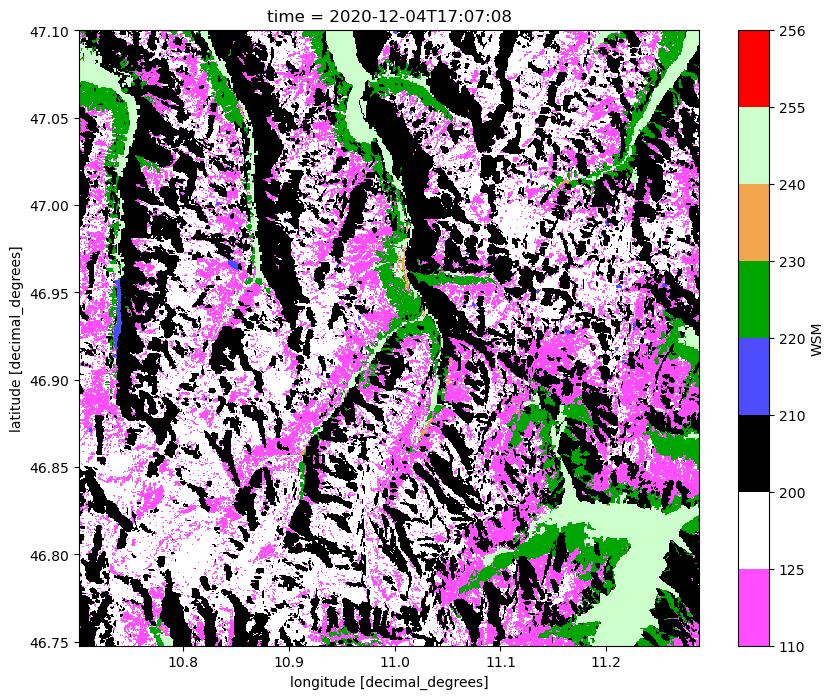

In [10]:
# Plot the Wet Snow Classification
sws_cmap = ListedColormap(["#ff4dff", "#ffffff", "#000000", "#4d4dff", "#00a600", "#f2a64d", "#ccffcc", "#ff0000"], )
sws_norm = BoundaryNorm([110, 125, 200, 210, 220, 230, 240, 255, 256], sws_cmap.N)
sws_xcube["WSM"].sel(time="2020-12-04 10:00:00", method='nearest').plot.imshow(figsize=(10,8), cmap=sws_cmap, norm=sws_norm)

## Visualising the Snow State Classification dataset over several dates

First we need to generate the datacube 

In [11]:
wds_bands = ['SSC', 'QCSSC', 'dataMask']
spatial_res_wds = 0.000540 # in degrees
wds_xcube = create_xcube_data(
    wds_bands, 
    aoi_coords, 
    projection_code_LAEA, 
    collection_ids.wds_collection, 
    sh_credentials, 
    ['2020-12-01','2021-05-31'], 
    no_data=np.nan,
    spatial_res=spatial_res_wds,
    creodias=True)

/opt/conda/envs/edc-default-2022.10-14/lib/python3.9/site-packages/xcube_sh/config.py:248: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  time_tolerance = pd.to_timedelta(time_tolerance)


Table 1: Classification classes and colouring scheme.

<table>
  <thead>
    <tr>
      <th>Value</th>
      <th>Color</th>
      <th>Label</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td style="background-color: #ff4dff;"></td>
      <td>110 - Wet snow</td>
    </tr>
    <tr>
      <td>2</td>
      <td style="background-color: #ffffff;"></td>
      <td>115 - Dry snow</td>
    </tr>
    <tr>
      <td>3</td>
      <td style="background-color: #e6e64d;"></td>
      <td>120 - Snow free or patchy snow</td>
    </tr>
    <tr>
      <td>4</td>
      <td style="background-color: #000000;"></td>
      <td>200 - Radar shadow / layover / foreshortening</td>
    </tr>
    <tr>
      <td>5</td>
      <td style="background-color: #cccccc;"></td>
      <td>205 - Cloud or cloud shadow</td>
    </tr>
    <tr>
      <td>6</td>
      <td style="background-color: #4d4dff;"></td>
      <td>210 - Water</td>
    </tr>
    <tr>
      <td>7</td>
      <td style="background-color: #00a600;"></td>
      <td>220 - Forest</td>
    </tr>
    <tr>
      <td>8</td>
      <td style="background-color: #f2a64d;"></td>
      <td>230 - Urban area</td>
    </tr>
    <tr>
      <td>9</td>
      <td style="background-color: #ff0000;"></td>
      <td>255 - No data</td>
    </tr>
</tbody>
</table>  

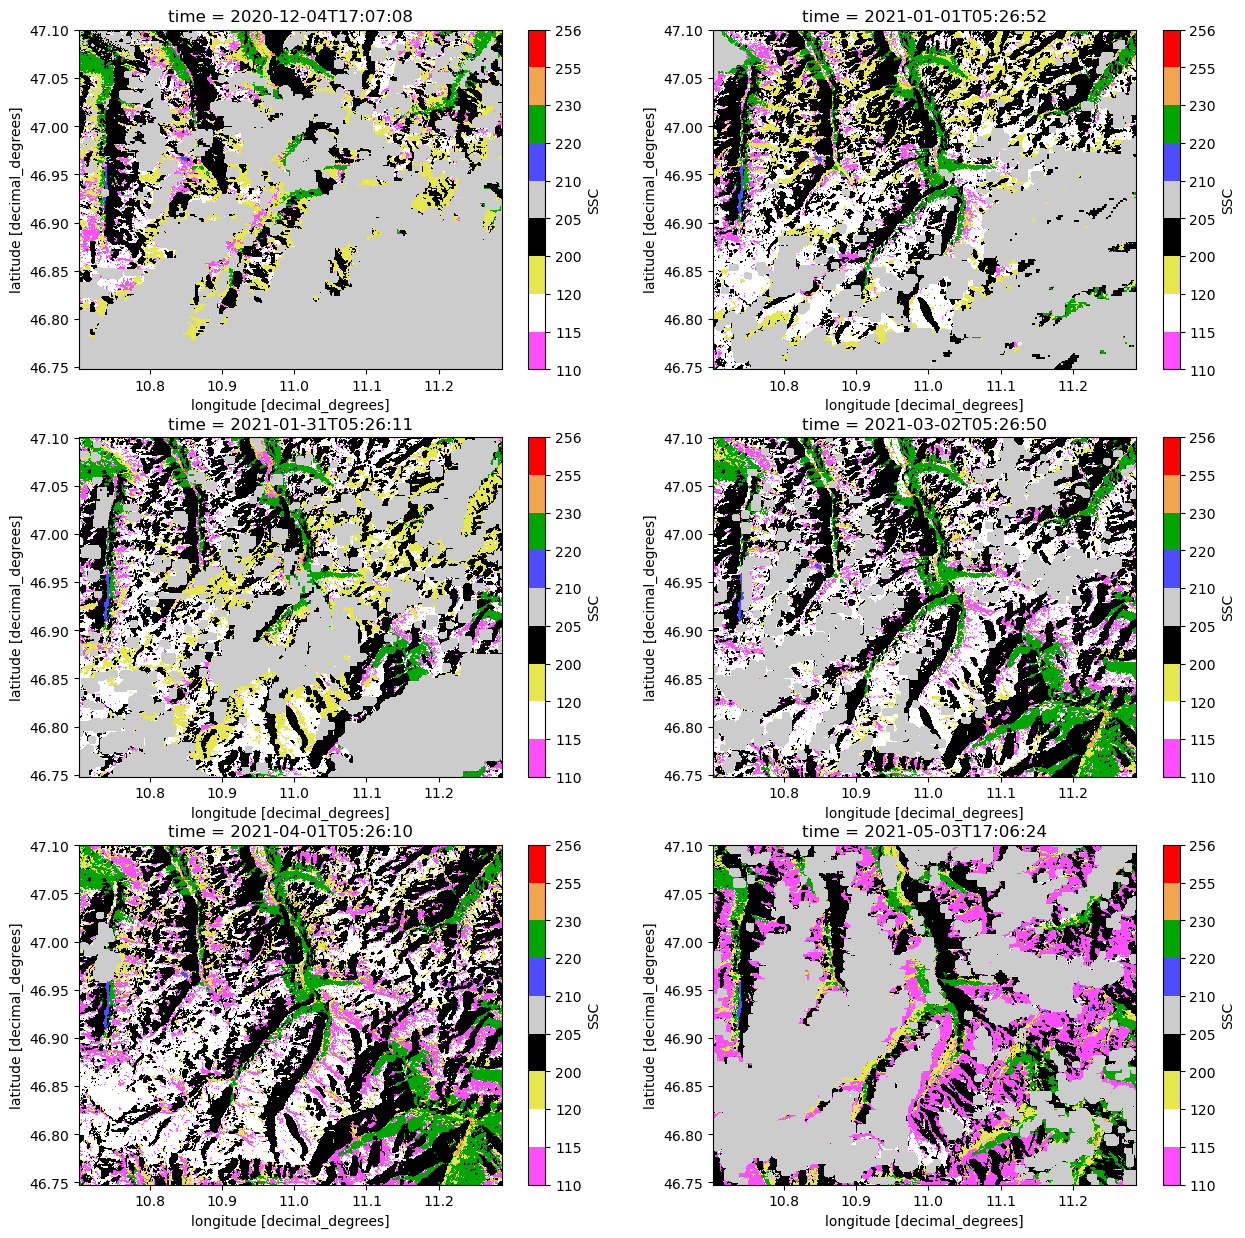

In [12]:
# Select timestamps
ssc1 = wds_xcube.SSC.sel(time='2020-12-01 10:00:00', method='nearest')
ssc2 = wds_xcube.SSC.sel(time='2021-01-01 10:00:00', method='nearest')
ssc3 = wds_xcube.SSC.sel(time='2021-02-01 10:00:00', method='nearest')
ssc4 = wds_xcube.SSC.sel(time='2021-03-01 10:00:00', method='nearest')
ssc5 = wds_xcube.SSC.sel(time='2021-04-01 10:00:00', method='nearest')
ssc6 = wds_xcube.SSC.sel(time='2021-05-01 10:00:00', method='nearest')

wds_cmap = ListedColormap(["#ff4dff", "#ffffff", "#e6e64d", "#000000", "#cccccc", "#4d4dff", "#00a600", "#f2a64d", "#ff0000"])
wds_norm = BoundaryNorm([110, 115, 120, 200, 205, 210, 220, 230, 255, 256], wds_cmap.N)

# Plot 
f = plt.figure(figsize=[15,15])
ax1 = f.add_subplot(3,2, 1)
ax2 = f.add_subplot(3,2, 2)
ax3 = f.add_subplot(3,2, 3)
ax4 = f.add_subplot(3,2, 4)
ax5 = f.add_subplot(3,2, 5)
ax6 = f.add_subplot(3,2, 6)

axlist=[ax1,ax2,ax3,ax4,ax5,ax6]

t = ssc1.plot.imshow(ax=ax1, cmap=wds_cmap, norm=wds_norm)
ssc2.plot.imshow(ax=ax2, cmap=wds_cmap, norm=wds_norm)
ssc3.plot.imshow(ax=ax3, cmap=wds_cmap, norm=wds_norm)
ssc4.plot.imshow(ax=ax4, cmap=wds_cmap, norm=wds_norm)
ssc5.plot.imshow(ax=ax5, cmap=wds_cmap, norm=wds_norm)
ssc6.plot.imshow(ax=ax6, cmap=wds_cmap, norm=wds_norm)

plt.show()

## Comparing Persistent snow area between different years

Next let's visualise how PSA can change between different years. First, we configure the datacube. 

In [13]:
psa_bands = ['PSA', 'QC', 'dataMask']
spatial_res_psa = 0.000180 # in degrees

psa_xcube = create_xcube_data(
    psa_bands, 
    aoi_coords, 
    projection_code_LAEA, 
    collection_ids.psa_collection, 
    sh_credentials, 
    ['2017-05-01','2021-05-31'], 
    no_data=np.nan,
    spatial_res=spatial_res_psa,
    creodias=True)

/opt/conda/envs/edc-default-2022.10-14/lib/python3.9/site-packages/xcube_sh/config.py:248: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  time_tolerance = pd.to_timedelta(time_tolerance)


In [14]:
psa_xcube

<xarray.Dataset>
Dimensions:    (time: 6, lat: 2328, lon: 3870, bnds: 2)
Coordinates:
  * lat        (lat) float64 47.17 47.17 47.17 47.17 ... 46.75 46.75 46.75 46.75
  * lon        (lon) float64 10.7 10.7 10.7 10.7 10.7 ... 11.4 11.4 11.4 11.4
  * time       (time) datetime64[ns] 2017-05-14 2017-05-17 ... 2021-05-03
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(6, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    PSA        (time, lat, lon) uint16 dask.array<chunksize=(1, 776, 1290), meta=np.ndarray>
    QC         (time, lat, lon) uint16 dask.array<chunksize=(1, 776, 1290), meta=np.ndarray>
    dataMask   (time, lat, lon) uint16 dask.array<chunksize=(1, 776, 1290), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   CUSTOM Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2023-01-20T03:56:24.365269
    time_coverage_start:     2017-05-14T00:00:00+00:00
    time_coverage_end:       2021-05-03T00:00:00+00:00
    time_coverage_duration:  P1450DT0H0M0S
    geospatial_lon_min:      10.70233
    geospatial_lat_min:      46.74815
    geospatial_lon_max:      11.39893
    geospatial_lat_max:      47.167190000000005

Let's plot the PSA for 2017 and 2020, and see if there is visually anything different between the two years.

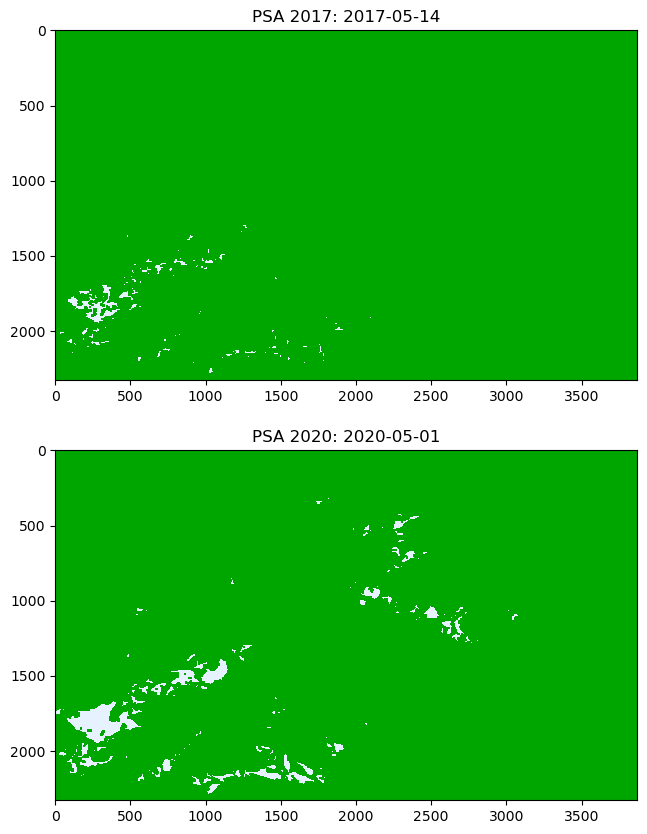

In [15]:
psa_cmap = ListedColormap(["#00a600", "#e6f2ff", "#000000"])
psa_norm = BoundaryNorm([0, 1, 255, 256], psa_cmap.N)
psa_2017 = psa_xcube["PSA"].sel(time="2017-05-03", method='nearest')
psa_2020 = psa_xcube["PSA"].sel(time="2020-05-03", method='nearest')

# Plot 
f = plt.figure(figsize=[10, 10])
f.add_subplot(2, 1, 1)
plt.title(f"PSA 2017: {str(psa_xcube.time.sel(time='2017-05-03', method='nearest').data).split('T')[0]}")
plt.imshow(psa_2017, cmap=psa_cmap, norm=psa_norm)
f.add_subplot(2, 1, 2)
plt.title(f"PSA 2020: {str(psa_xcube.time.sel(time='2020-05-03', method='nearest').data).split('T')[0]}")
plt.imshow(psa_2020, cmap=psa_cmap, norm=psa_norm)
plt.show()

It seems that 2017 was an extremely dry year with very little persistent snow area in our area of interest. Let's extract out the areas which saw changes between the two years. We can do this by calculating a new variable in the cell below, and then visualising this new variable in a plot.

In [16]:
difference = psa_2017 - psa_2020

difference.attrs['long_name']='difference'
difference.attrs['units']='nounits'

psa_xcube['difference']= difference

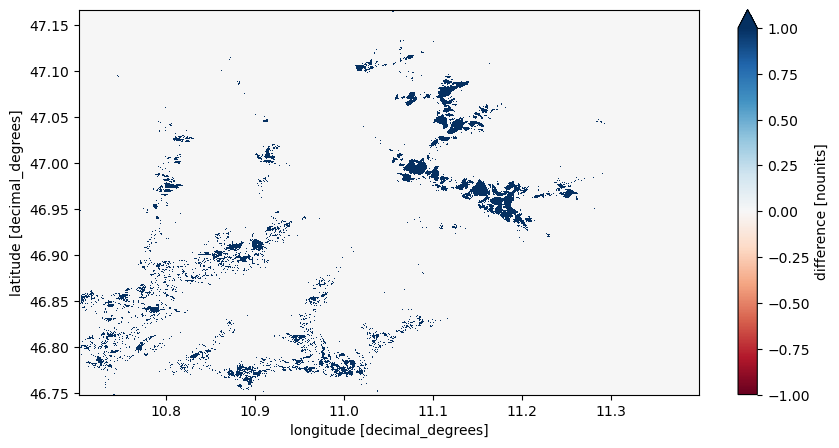

In [17]:
difference.plot.imshow(cmap='RdBu', vmin=-1, vmax=1, figsize=(10, 5))
plt.show()

## Plotting a time series of Gap Filled Fractional Snow Cover over a season:

In this example we will subset our datacube to a smaller field of interest within our AOI using a geojson. We will then calculate the mean GFSC in this field and then plot this. Firstly, let's configure our datacube:

In [18]:
gfsc_bands = ['GF', 'QC', 'dataMask']
spatial_res_gfsc = 0.000540 # in degrees

gfsc_xcube = create_xcube_data(
    gfsc_bands, 
    aoi_coords, 
    projection_code_LAEA, 
    collection_ids.gfsc_collection, 
    sh_credentials, 
    ['2019-10-01','2020-07-31'], 
    no_data=np.nan,
    spatial_res=spatial_res_gfsc,
    creodias=True)

/opt/conda/envs/edc-default-2022.10-14/lib/python3.9/site-packages/xcube_sh/config.py:248: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  time_tolerance = pd.to_timedelta(time_tolerance)


In [19]:
gfsc_xcube

<xarray.Dataset>
Dimensions:    (time: 124, lat: 653, lon: 1085, bnds: 2)
Coordinates:
  * lat        (lat) float64 47.1 47.1 47.1 47.1 ... 46.75 46.75 46.75 46.75
  * lon        (lon) float64 10.7 10.7 10.7 10.7 ... 11.29 11.29 11.29 11.29
  * time       (time) datetime64[ns] 2019-10-04 2019-10-06 ... 2020-07-28
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(124, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    GF         (time, lat, lon) uint16 dask.array<chunksize=(1, 653, 1085), meta=np.ndarray>
    QC         (time, lat, lon) uint16 dask.array<chunksize=(1, 653, 1085), meta=np.ndarray>
    dataMask   (time, lat, lon) uint16 dask.array<chunksize=(1, 653, 1085), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   CUSTOM Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2023-01-20T03:59:10.102852
    time_coverage_start:     2019-10-04T00:00:00+00:00
    time_coverage_end:       2020-07-28T00:00:00+00:00
    time_coverage_duration:  P298DT0H0M0S
    geospatial_lon_min:      10.70197
    geospatial_lat_min:      46.74779
    geospatial_lon_max:      11.28787
    geospatial_lat_max:      47.100410000000004

Next, we have already generated a GeoJSON of a field in the AOI. First let's import the GeoJSON and visualise it:

In [20]:
field = {
  "type": "Polygon",
  "coordinates": [
    [
      [
        11.021908,
        46.864064
      ],
      [
        11.021126,
        46.863181
      ],
      [
        11.02058,
        46.863272
      ],
      [
        11.020318,
        46.862925
      ],
      [
        11.023432,
        46.86173
      ],
      [
        11.025748,
        46.860514
      ],
      [
        11.027293,
        46.861717
      ],
      [
        11.024013,
        46.863331
      ],
      [
        11.021908,
        46.864064
      ]
    ]
  ]
}

IPython.display.GeoJSON(field)

<IPython.display.GeoJSON object>

We can now subset our datacube using the function below:

In [21]:
subset_xcube = mask_dataset_by_geometry(gfsc_xcube, geometry=field)

Next, let's plot the GFSC in our subsetted area.

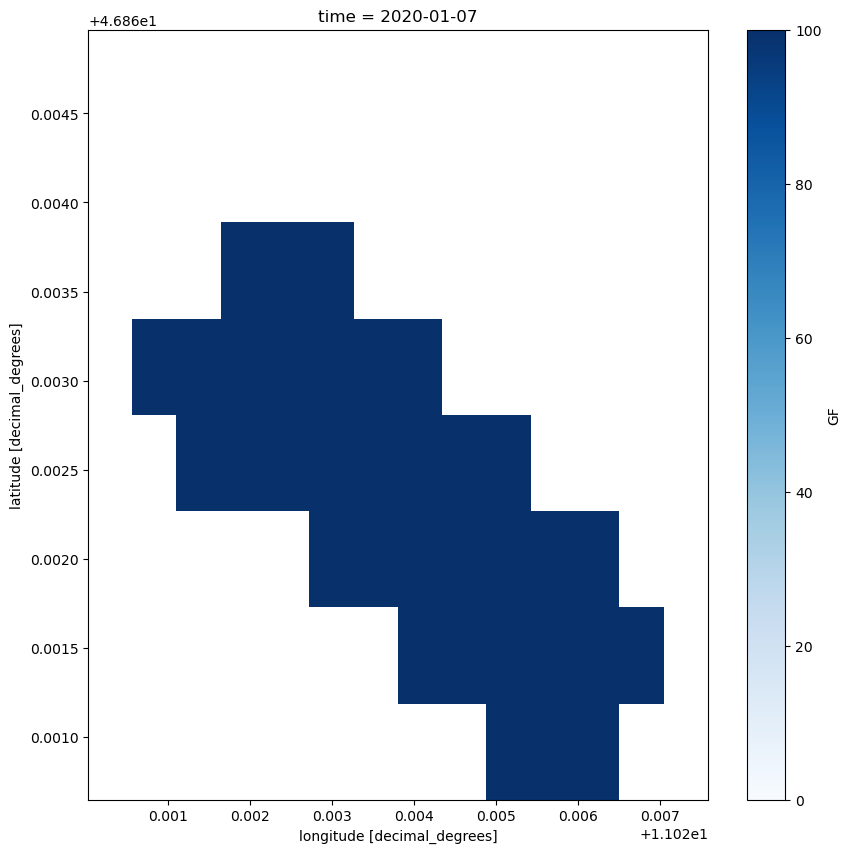

In [23]:
subset_xcube.GF.isel(time=40).plot.imshow(cmap='Blues', vmin=0, vmax=100, figsize=(10, 10))
plt.show()

OK, this looks good, now we are now going to calculate the mean GFSC value across the field for each time step. Firstly, we want to calculate the mean GFSC on axis 1 (lat) and 2 (lon). The second function removes any observations with values of 0 (observations that don't cover our field of interest). Visualising this array we have 73 timesteps each assigned the mean value of the field.

In [24]:
# cloud masking for each time step
timeseries = subset_xcube.where(subset_xcube.GF <= 100)

# calculate the mean FSC for each time step
mean_timeseries = timeseries.GF.mean(axis=(1,2), skipna=True)

# remove any observations with no data
mean_timeseries = mean_timeseries.where(mean_timeseries !=0).dropna("time")

# return the new data cube chunk
mean_timeseries

<xarray.DataArray 'GF' (time: 84)>
dask.array<getitem, shape=(84,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-10-16 2019-11-02 ... 2020-05-30

Next we can plot this new array we have generated. The result shows little fluctuation in GFSC over the time period for this field indicating it was covered in snow for most of the time period.

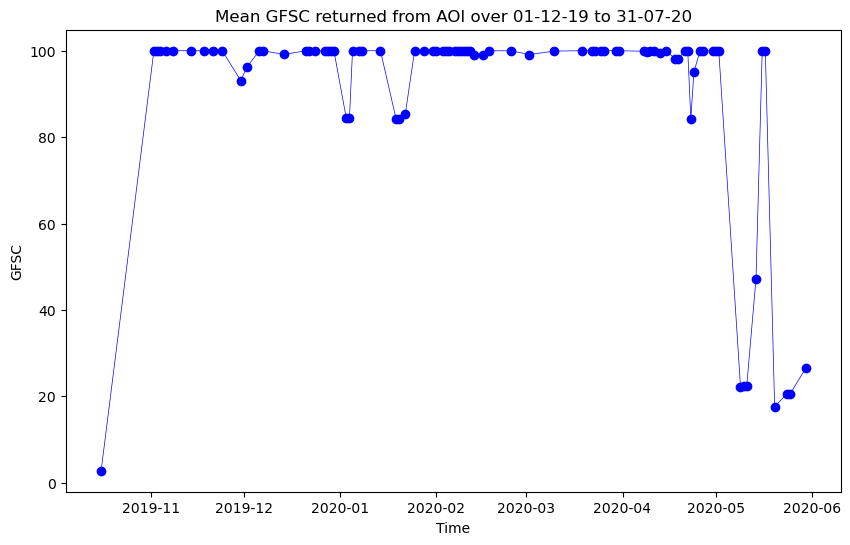

In [30]:
# Plot timeseries
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(mean_timeseries.time, mean_timeseries, color="blue", marker="o", linewidth=0.5)
ax.set_title("Mean GFSC returned from AOI over 01-12-19 to 31-07-20")
ax.set_xlabel('Time')
ax.set_ylabel('GFSC')
plt.show()

## Summary

So what have we learned in this notebook? We have learnt how to…

- Configure and visualise a datacube using xcube
- Visualise change over time and space.
- Create a time series analysis of a variable.

### The Disclaimer!

- xcube is a great tool to quickly access datasets.
- It's great for prototyping on smaller areas of interest.
- You can quickly achieve a quick and dirty analysis like I have done here.
- But this is not the tool to use when you want to scale up your applications though.
- Not built for huge datasets, but good news... next we're going to show you what tools you can use to scale up your analysis! 